In [111]:
import math
import mmh3
import numpy as np


#define quotient filter class
class quotient_filter:
    #this determines the size of the filter for particular capacity and error rate
    #this allows us to determine the quotient and remainder sizes
    
    def __init__(self,capacity, alpha = None, error=0.01):
        self.error = error
        if capacity <= 0:
            raise ValueError("You should store some elements")
        if self.error <= 0 or self.error >=1:
            raise ValueError("Error rate should be a probability between 0 and 1")
        self.r = int(-math.log(error,2))
        if alpha is None:
            self.m = int(-capacity/(math.log(1-error)*2**self.r))
            self.q = int(math.log(self.m,2))
        else:
            if alpha <= 0 or alpha >1:
                raise ValueError("Load factor should be between 0 and 1")
            self.m = int(capacity/alpha)
            self.q = int(math.ceil(math.log(self.m,2)))
        #check that q + r ≤ 64 bits
        if self.r + self.q > 64:
            raise ValueError("The quotient and remainder total should be no more than 64")
        #now can create filter, with 4 indexed values: remainder, is_occupied, is_continuation, is_shifted
        self.array = np.array([[None,False,False,False] for i in range(self.m)])
        
    def find_element(self, element):
        #determine the quotient and remainder for an element
        #use hash function and partition accordingly
        quotient = mmh3.hash(element) // (2 ** self.r) % self.m
        remainder = mmh3.hash(element) % (2 ** self.r)
        return quotient, remainder

    def is_empty(self,index):
        #check whether the index is empty
        #if the final three values in array for index are zero, empty
        for i in range(1,4):
            if self.array[index][i] == True:
                return False
        return True  

    def is_run_start(self,index):
        #check if the index is the beginning of a run
        #if is_continuation is false and either is_occuppied or is_shifted is 1, yes
        if self.array[index][2] == False and (self.array[index][1] or self.array[index][3]) == True:
            return True
        else:
            return False

    def is_cluster_start(self,index):
        #check if the index is the beginning of a cluster
        #if is_occupied = 1, yes
        if self.array[index][1] == True and self.is_empty(index)==True:
            return True
        else:
            return False

    def find_run_start(self,index):
        #find the start of the run for this index
        #move backwards until reach beginning of a cluster, adding runs
        #for loop will circle to end of filter if not found by start
        runs = 0
        for i in range(index, -1, -1) + range(index, self.m)[::-1]:
            if self.is_empty(i) == False and self.array[i][3] == False:
                break
            if self.array[i][1] == True:
                runs +=1
        #move forwards, subtracting runs, when reach zero, give index
        #for loop will circle to beginning if not found by end
        for j in range(i, self.m) + range(i):
            if self.array[j][2] == False:
                runs -= 1
            if runs ==0:
                break
        return j

    def search(self, element):
        #see whether element capable of being in the filter
        #determine quotient and remainder
        quotient, remainder = self.find_element(element)
        #first check canonical slot for quotient
        if self.array[quotient][1] == False:
            return False
        #otherwise find beginning of run
        run_start = self.find_run_start(quotient)
        #search through run for remainder, if no longer in run, false
        for i in range(run_start,self.m) + range(run_start):
            if remainder == self.array[i][0]:
                return True
            if self.array[i][3] == False and i!=run_start:
                return False
        return False

    def insert(self,element):
        #first check if the element is already in the filter
        if self.search(element) == True:
            return
        #otherwise proceed to check canonical slot
        else:
            quotient, remainder = self.find_element(element)
            if self.is_empty(quotient) == True:
                self.array[quotient][0] = remainder
                self.array[quotient][1] = True
                return
            if self.array[quotient][1] == False:
                self.array[quotient][1] = True
        #find run start
            run_start = self.find_run_start(quotient)
            if self.array[quotient][1] == True:
                for i in range(run_start,self.m) + range(run_start):
                    if remainder < self.array[i][0]:
                        break
                    elif self.array[i][3] == False and i!=quotient:
                        break
                    elif self.array[i][2] == False and i!=quotient:
                        break
                #if there's no element in the corresponding slot
                #insert element and update bits
                if self.array[i][0] is None:
                    self.array[i][0] = remainder
                    if i!= quotient:
                        self.array[i][3] = True
                    if self.is_run_start(i) == False:
                        self.array[i][2] = True
                    return
                #otherwise we need to swap the elements, update bits
                self.array[i][0], remainder = remainder, self.array[i][0]
                if i!= quotient:
                    self.array[i][3] = True
                if self.is_run_start(i) == False:
                    self.array[i][2] = True
                #next, move remainders and forward by 1
                #and update bfits as required
                for j in range(i+1,self.m)+range(i):
                    if self.array[j][0] is None:
                        self.array[j][0] = remainder
                        if self.array[j][3] == False:
                            self.array[j][3] = True
                        if self.is_run_start(j-1) == True:
                            self.array[j][2] = True
                        return
                    self.array[j][0], remainder = remainder, self.array[j][0]
                    if j == self.find_run_start(j):
                        self.array[j][2] = True
                    if self.array[j][3] == False:
                        self.array[j][3] = True
            
            


In [106]:
n = 100 #no of items to add
p = 0.05 #false positive probability
from random import shuffle
qf = quotient_filter(n,alpha=0.5)
print("Size of bit array:{}".format(qf.m))
print("False positive Probability:{}".format(qf.error))
 
# words to be added
from random_words import RandomWords
rw = RandomWords()
word_present = [rw.random_word('a') for i in range(100)]
 
# word not added
word_absent = [rw.random_word('b') for i in range(25)]
 
for item in word_present:
    qf.insert(item)

shuffle(word_present)
shuffle(word_absent)
 
test_words = word_present + word_absent
shuffle(test_words)
fp = 0
fn = 0
for word in test_words:
    if qf.search(word):
        if word in word_absent:
            print("'{}' is a false positive!".format(word))
            fp +=1
        else:
            print("'{}' is probably present!".format(word))
    else:
        if word in word_present:
            print("'{}' is a false negative!".format(word))
            fn +=1
        print("'{}' is definitely not present!".format(word))
print("False positive rate: " + str(float(fp)/len(test_words)))
print("False negative rate: " + str(float(fn)/len(test_words)))

Size of bit array:200
False positive Probability:0.01
'buoys' is definitely not present!
'adherence' is probably present!
'airplanes' is probably present!
'blindfold' is definitely not present!
'answer' is probably present!
'breasts' is definitely not present!
'articles' is probably present!
'alcoholics' is probably present!
'atmospheres' is probably present!
'allegation' is probably present!
'aviation' is probably present!
'alloy' is probably present!
'award' is probably present!
'accord' is a false negative!
'accord' is definitely not present!
'approval' is probably present!
'acquisitions' is probably present!
'barrier' is definitely not present!
'airfield' is probably present!
'breasts' is definitely not present!
'apportionment' is probably present!
'base' is definitely not present!
'airspeed' is probably present!
'audit' is probably present!
'attraction' is probably present!
'additions' is probably present!
'auditors' is probably present!
'agreement' is probably present!
'asterisks

In [119]:
#simulation for time complexity for insertions and searches
#import necessary packages
import random
from random import shuffle
from random_words import RandomWords
rw = RandomWords()
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#create arrays to store data for plotting
all_inserts = []
all_searches = []
all_fp = []
#loop for increasing lengths of list in increments of 100
for j in range(100,5100, 100):
    print j
    qf = quotient_filter(j,alpha=0.5)
#arrays to store each repeat at the same list length
    time_insert = []
    time_search = []
    fp_count = []
#repeat the algorithms 25 times to obtain an average
    for i in range(25):
#generate a random list of integers
        word_present = [rw.random_word('a') for x in range(j)]
#time and run the two operations, adding each time to relevant aray
        start_insert = datetime.now()
        for item in word_present:
            qf.insert(item)
        time_insert.append((datetime.now() - start_insert).total_seconds())
        start_search = datetime.now()
        word_absent = [rw.random_word('b') for x in range(j/2)]
        shuffle(word_present)
        shuffle(word_absent)
        test_words = word_present[:(j/2)] + word_absent
        shuffle(test_words)
        for word in test_words:
            qf.search(word)
        time_search.append((datetime.now() - start_search).total_seconds())
        for word in test_words:
            qf.search(word)
            if word in word_absent:
                fp +=1
        fp_count.append(fp)
#determine the average and add to array for plotting
    all_inserts.append(sum(time_insert)/len(time_insert))
    all_searches.append(sum(time_search)/len(time_search))
    all_fp.append((float(sum(fp_count)))/(j*25))
    

#generate the corresponding list lengths for the times
x = [100*i for i in range(1,51)]
#plot the data for the three algorithms
plt.plot(x,all_inserts, label="Insertions")
plt.plot(x,all_searches, label="Searches")
#label the axes and add a legend
plt.xlabel("Number (n)")
plt.ylabel("Running time (s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(x,all_fp)
plt.xlabel("Number (n)")
plt.ylabel("False positive rate (fp)")
plt.show()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


KeyboardInterrupt: 

TypeError: a float is required

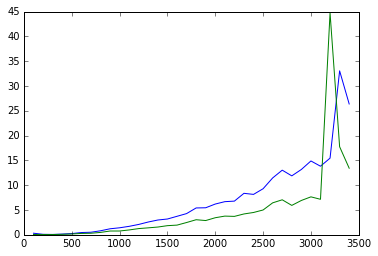

In [124]:
#generate the corresponding list lengths for the times
x = [100*i for i in range(1,35)]
#plot the data for the two operations
plt.plot(x,all_inserts, label="Insertions")
plt.plot(x,all_searches, label="Searches")
plt.plot(x,math.log(x),label="log(x)")
#label the axes and add a legend
plt.xlabel("Number (n)")
plt.ylabel("Running time (s)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(x,all_fp)
plt.xlabel("Number of insertions, number of searches (n)")
plt.ylabel("False positive rate (fp)")
plt.show()

In [122]:
len(all_inserts)

34